#Dataset
https://www.cryptodatadownload.com/data/bitfinex/

- Unix Timestamp - This is the unix timestamp or also known as "Epoch Time". Use this to convert to your local timezone \
- Date - This timestamp is converted to NY EST Standard Time \
- Symbol - The symbol for which the timeseries data refers \
- Open - This is the opening price of the time period \
- High - This is the highest price of the time period \
- Low - This is the lowest price of the time period \
- Close - This is the closing price of the time period \
- Volume (Crypto) - This is the volume in the transacted Ccy. Ie. For BTC/USD, this is in BTC amount \
- Volume Base Ccy - This is the volume in the base/converted ccy. Ie. For BTC/USD, this is in USD amount

#Deep Learning Model
##RNN Model
![](https://i1.wp.com/nttuan8.com/wp-content/uploads/2019/05/loss.png?w=1025&ssl=1)

##LSTM Model
![](https://i2.wp.com/nttuan8.com/wp-content/uploads/2019/06/lstm.png?w=1003&ssl=1)

##Input format
![](https://4.bp.blogspot.com/-duOcCEd9DJU/XMSJD6kzDJI/AAAAAAAAqd4/xlbs2_fbw248QJGkahI5IJJeOHEMBJKdwCLcBGAs/s1600/nn2.png)

##Dataset
data = [1,2,3,4,5,6,7,8,9,10,11,12]

timesteps = 3

###Input data

| X      | y |
| ----------- | ----------- |
| 1, 2, 3      | 4       |
| 2, 3, 4   | 5        |
| 3, 4, 5   | 6        |
| 4, 5, 6   | 7        |
| ... | ... |



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

#Configure

In [ ]:
train_size_percent = 0.80
n_step = 24*60 # 24h * 30 days
lstm_layers = 50
epochs=10
batch_size=32

#Đọc dữ liệu thô



In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bitfinex_BTCUSD_1h.csv')

print(f'Kiểu dữ liệu: \n{df.dtypes}')
print('-------------------------------------------------------------------------')
print(f'Đếm số dòng dữ liệu bị null: \n{df.isna().sum()}')
print('-------------------------------------------------------------------------')
print(f'Dữ liệu: \n{df}')

Kiểu dữ liệu: 
unix          float64
date           object
symbol         object
open          float64
high          float64
low           float64
close         float64
Volume USD    float64
Volume BTC    float64
dtype: object
-------------------------------------------------------------------------
Đếm số dòng dữ liệu bị null: 
unix          0
date          0
symbol        0
open          0
high          0
low           0
close         0
Volume USD    0
Volume BTC    0
dtype: int64
-------------------------------------------------------------------------
Dữ liệu: 
               unix           date   symbol         open        high      low  \
0      1.650850e+12  4/25/22 01:00  BTC/USD  38891.00000  39023.0000  38792.0   
1      1.650840e+12  4/25/22 00:00  BTC/USD  39473.00000  39526.0000  38706.0   
2      1.650840e+12  4/24/22 23:00  BTC/USD  39588.00000  39593.5856  39461.0   
3      1.650840e+12  4/24/22 22:00  BTC/USD  39669.00000  39798.0000  39566.0   
4      1.650830e+12  4/

#Features engineering

In [ ]:
# Xoá cột dữ liệu không dùng
del df['unix'], df['symbol']

# Dùng cột 'date' để làm index và chỉ lấy thông tin từ 2020 trở về nay
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by="date")
df = df.loc[df['date'] >= '2020-01-01 00:00:00']
df = df.set_index('date')

# Sắp xếp các cột dữ liệu
df = df[["open", "high", "low", "Volume USD", "Volume BTC", "close"]]

print(df)

                            open        high      low    Volume USD  \
date                                                                  
2020-01-01 00:00:00   7208.30000   7208.3000   7185.4  7.644562e+05   
2020-01-01 01:00:00   7189.81000   7250.0000   7187.4  4.463800e+05   
2020-01-01 02:00:00   7227.80000   7256.7000   7227.8  2.511332e+05   
2020-01-01 03:00:00   7256.70000   7256.7000   7233.1  2.323107e+05   
2020-01-01 04:00:00   7237.30000   7241.3000   7226.1  3.760059e+05   
...                          ...         ...      ...           ...   
2022-04-24 21:00:00  39526.97773  39670.0000  39505.0  6.064814e+06   
2022-04-24 22:00:00  39669.00000  39798.0000  39566.0  2.804386e+06   
2022-04-24 23:00:00  39588.00000  39593.5856  39461.0  2.732270e+06   
2022-04-25 00:00:00  39473.00000  39526.0000  38706.0  1.581402e+07   
2022-04-25 01:00:00  38891.00000  39023.0000  38792.0  3.316250e+06   

                     Volume BTC        close  
date                         

#Train, Test split

In [ ]:
# We want 80% of the data to be used for training, and 20% for testing
n_train_rows = int(df.shape[0]*train_size_percent)-1

# Split into train and test sets but keep all 6 columns
train = df.iloc[:n_train_rows, :]
test = df.iloc[n_train_rows:, :]

# The total rows of the two datasets should equal the total amount of rows in your CSV
print(train.shape)
print(test.shape)

(16183, 6)
(4047, 6)


In [ ]:
train.tail()

,open,high,low,Volume USD,Volume BTC,close
date,,,,,,
2021-11-05 06:00:00,62179.16501,62600.00000,62179.16501,8797504.976,141.425344,62206.00000
2021-11-05 07:00:00,62217.00000,62495.00000,62138.00000,2611862.682,42.017707,62161.00000
2021-11-05 08:00:00,62162.94015,62235.00000,62006.00000,4484213.176,72.073761,62217.00000
2021-11-05 09:00:00,62235.00000,62254.00000,61571.00000,6837388.429,110.780759,61720.00000
2021-11-05 10:00:00,61738.00000,61810.03988,61494.00000,2718893.925,44.138585,61599.02723


#Normalise features

In [ ]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train.values)
test_set_scaled = sc.fit_transform(test.values)

print(training_set_scaled)

[[4.64479913e-02 4.09019259e-02 5.10949891e-02 1.57017826e-03
  4.40795099e-03 4.61522838e-02]
 [4.61522838e-02 4.15712914e-02 5.11270698e-02 9.16856013e-04
  2.56179740e-03 4.67598516e-02]
 [4.67598516e-02 4.16788394e-02 5.17751007e-02 5.15822843e-04
  1.43792547e-03 4.72220445e-02]
 ...
 [9.25328495e-01 9.24186729e-01 9.30437601e-01 9.21048758e-03
  2.99009511e-03 9.26193066e-01]
 [9.26480937e-01 9.24491716e-01 9.23460041e-01 1.40438643e-02
  4.59591675e-03 9.18244626e-01]
 [9.18532497e-01 9.17365298e-01 9.22224933e-01 5.58455581e-03
  1.83115973e-03 9.16309929e-01]]


#Prepare data

In [ ]:
def create_dataset(dataset, n_step=50):
  dataX, dataY = [], []
  for i in range(n_step, len(dataset)):
    dataX.append(dataset[i-n_step:i, :])
    dataY.append(dataset[i])
  return np.array(dataX), np.array(dataY)

x_train, y_train = create_dataset(training_set_scaled, n_step=n_step)
x_test, y_test = create_dataset(test_set_scaled, n_step=n_step)

print(f'x_train: {x_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'x_test: {x_test.shape}')
print(f'y_test: {y_test.shape}')

x_train: (14743, 1440, 6)
y_train: (14743, 6)
x_test: (2607, 1440, 6)
y_test: (2607, 6)


#Model LSTM

In [ ]:
model = Sequential()
model.add(LSTM(units=64, return_sequences = True, input_shape = (n_step, 6)))
model.add(Dropout(0.3))
model.add(LSTM(units=32))
model.add(Dropout(0.3))
model.add(Dense(units=6))

model.compile(loss="mse", optimizer="adam")
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=5)

Epoch 1/5
461/461 [==============================] - 41s 77ms/step - loss: 0.0095
Epoch 2/5
461/461 [==============================] - 35s 77ms/step - loss: 0.0033
Epoch 3/5
461/461 [==============================] - 35s 76ms/step - loss: 0.0023
Epoch 4/5
461/461 [==============================] - 35s 76ms/step - loss: 0.0019
Epoch 5/5
461/461 [==============================] - 35s 76ms/step - loss: 0.0017


# Predict values from test data trained using training data

In [ ]:
y_hat = model.predict(x_test)
y_hat = sc.inverse_transform(y_hat)

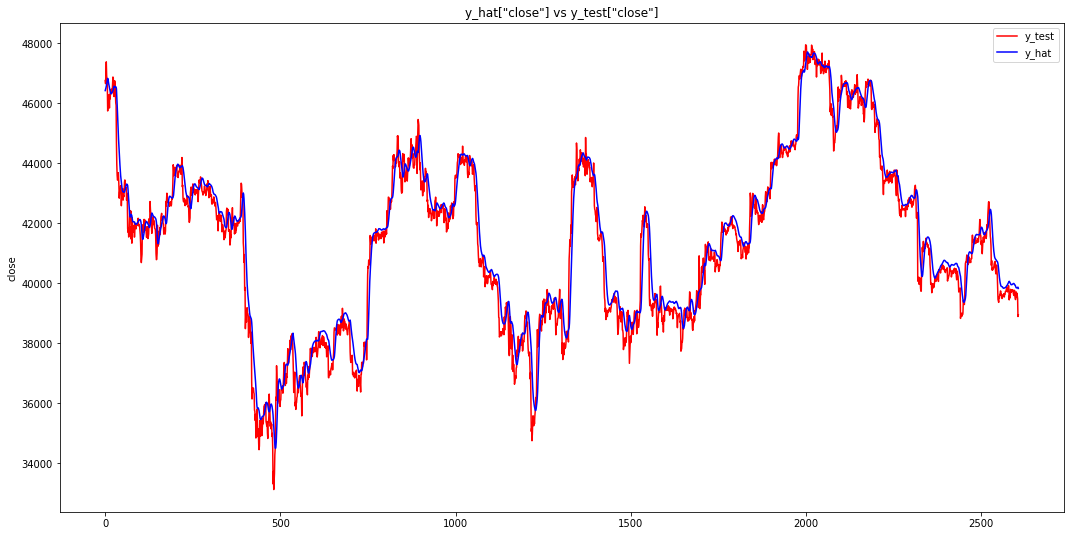

In [ ]:
y_test = test[n_step:].reset_index(drop=True)

plt.figure(figsize = (18,9))
plt.plot(y_test['close'], color = 'red', label = 'y_test')
plt.plot(y_hat[:,0], color = 'blue', label = 'y_hat')
plt.title('y_hat["close"] vs y_test["close"]')
plt.ylabel('close')
plt.legend()
plt.show()